# Non-Adiabatic Particle In A Box

This Notebook is compatible with Jupiter Notebook v6.5.3

## Import Necessary Packages

The packages necessary for running this code can be install directly in the Jupyter Notebook if not already installed. Simply uncomment the lines in the below cell and run it.

<i>Note: The above only has to be done once, so please make sure to comment out the below cell to ensure you aren't trying to install the packages each time you run the Notebook!</i>

In [1]:
#pip install numpy
#pip install matplotlib
#pip install scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter #PillowWriter
from scipy.linalg import eigh
from scipy.io import wavfile # for sound waves

## Plotting Energy Levels

The energy levels for a particle in an <i>infinite</i> box can be plotted below. Although the code presented in our simulations employ a finite-depth well, the energy levels of an infinite box can provide qualitative insights into how box length affects said values. This can help us make predictions as to which excited states (n > 1) will mix with our ground state (n = 1) as the box grows.

In [3]:
%matplotlib inline

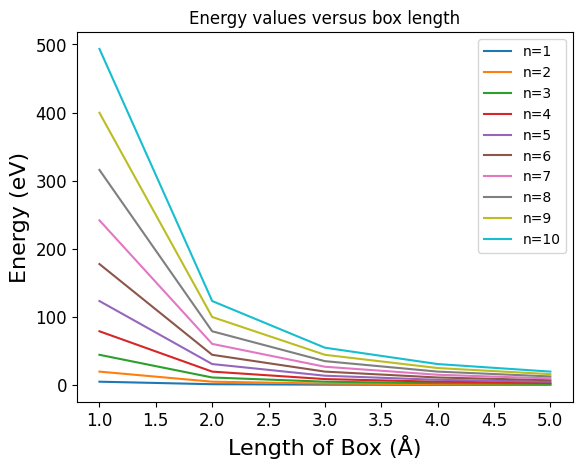

In [4]:
m = 1
pi = math.pi
hbar = 1

def E(n, L):
    return (n**2 * pi**2 * hbar**2) / (2 * m * L**2)

Elist = []

mm = 6
xr = range(1, mm)

for n in range(1, 11):
    Elist = [E(n, l) for l in xr]
    plt.plot(xr, Elist, label=f'n={n}')
    
plt.legend()
plt.xlabel("Length of Box (Å)", fontsize=16)
plt.ylabel("Energy (eV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Energy values versus box length")
plt.show()

# Define Constants and Parameters

In the following cell, we define the constants and parameters we are going to be using in our simulation. Because we are working with a particle in a box, single-particle model, we are going to use atomic units to simplify our calculations. In doing so, many of our constants simplify to one.

In [5]:
# Atomic base units:
hbar = 1  # reduced Planck constant
me = 1  # mass of electron

# Convenient units in terms of atomic units:
angs = 1 / 0.529177  # length
fs = 1 / (1e15 * 2.4188843265864e-17)  # time
eV = 1 / 27.211386245988  # energy

pi = math.pi

mu = 1 * me # reduced mass

## Set Type to "Notebook" (allows animations)

In [6]:
%matplotlib notebook

# Adjustable Variables

There are quite a few variables we encourage users to manipulate to reveal different trends and gain a deeper understanding of the simulation. They are defined as follows:

`well_depth`: The depth of the well. The default is 2 eV

`PES`: The potential energy function. This is defined currently as a square well. The following functions help define the PES:
- `E0`: The energy within the well
- `dr`: The step size for the distance (x-axis)
- `r`: The distance the x-axis spans
- `r0L`: The starting distance for one side of the well
- `r0L`: The starting distance for the opposite side of the well

`speed_coeff`: The speed at which the box expands. We provide two options in the literature, 0.5 fs and 4.5 fs.

`expansiondistance`: The distance the box will expand by. The default is 20 Å.

In [7]:
well_depth = 2

# Variables needed for the potential energy term:
E0 = well_depth * eV 
dr = 0.3 * angs 
r = np.arange(-35 * angs, 35 * angs, dr) 
r0L = 45 * angs 
r0R = 5 * angs 

PES = -E0 * (1 - np.heaviside(r - r0R /2, 0.5)) * np.heaviside(r + r0L /2, 0.5)

speed_coeff = 4.5

expansiondistance = 20 * angs

# Run the Simulation

There are a few sections which can be uncommented, depending on the goal of use for the simulation: 

1. Inside the `update_plot(j)` function, **lines 141-143**. These lines, when uncommented, will save each sound generated every ten time steps to individual wave files. These files can then be processed with a secondary script, **combine_audio.ipynb** to join them into one continuous audio file.
<br>
<br>
2. The last lines of the file, **lines 154-155**. These lines, when uncommented, will save the simulation to an **.mp4** file. Please note this cannot run and have the simulation visualized in the Jupyter Notebook at the same time. For strictly educational and experimental purposes where the video file is not needed, we recommend running the simulation solely in the Jupyter Notebook without saving. Within these lines, one can customize the name of the file with the `filename` variable.

<IPython.core.display.Javascript object>


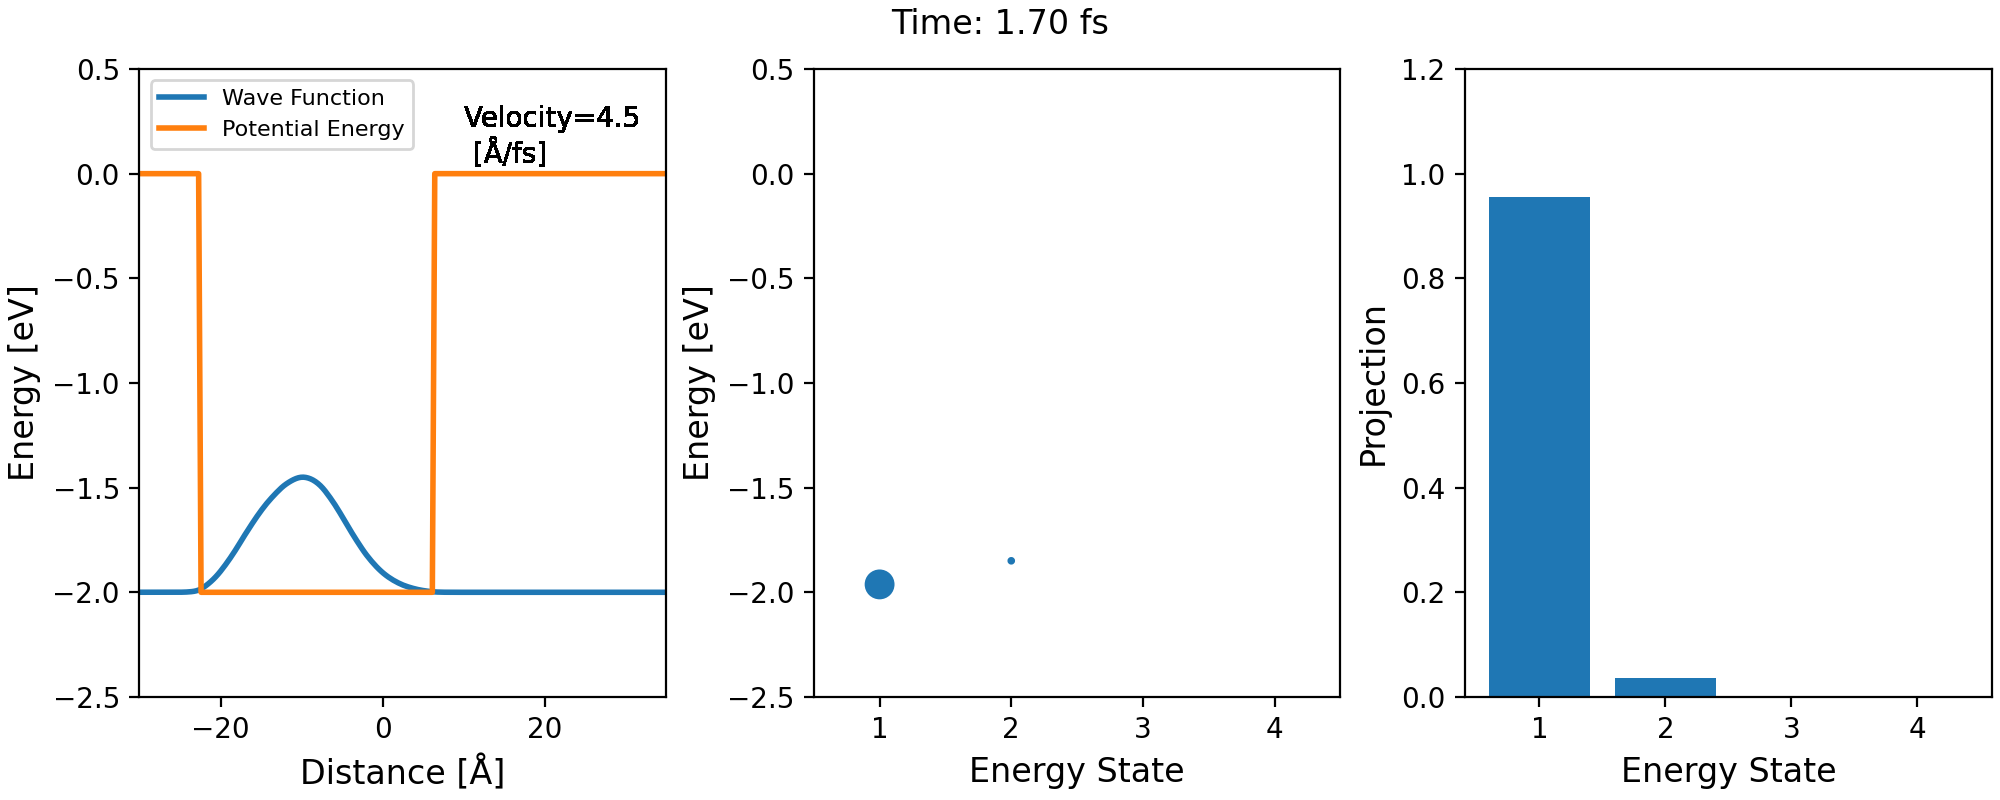

In [8]:
# === Define Kinetic Energy and Potential Energy Equations (Do Not Change) === #

# Kinetic energy prefactor
kinEPrefactor = -(1 / (dr ** 2)) * hbar ** 2 / (2 * mu)

# Hamiltonian
H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)
# === END === #

# === Solve Hamiltonian for Eigenvalues: Energies and Wave Function (Psig) (Do Not Change) === #
Energies, wavefuncs = eigh(H)
Eg = np.diag(Energies)
Psig = wavefuncs[:, 0]
# === END === #

# === Define Expanding Box === #
dt = 0.01 * fs

# For fast expansion, coeff = 4.5, for slow expansion, coeff = 0.5
velocity = speed_coeff * angs / fs

expansiondistance = 20 * angs
tfinal = (2 * expansiondistance) / velocity
#t = np.arange(0, tfinal + 100 * fs, dt)
t = np.arange(0, tfinal + 1 * fs, dt) # maybe change so this counts up by 10s?
# === END === #

Psi = Psig.copy()


# === Initialize plot (Do Not Change) === #
fig, ax = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
ax[0].set_xlim(r[0] / angs + 5, r[-1] / angs)
ax[0].set_ylim(-well_depth-0.5, 0.5)
wave_plot, = ax[0].plot([], [], lw=2, label="Wave Function")
pes_plot, = ax[0].plot([], [], lw=2, label="Potential Energy")

ax[0].set_ylabel("Energy [eV]", fontsize=12)
ax[0].set_xlabel("Distance [Å]", fontsize=12)
ax[0].legend(loc="upper left", fontsize=8)

ax[1].set_ylabel("Energy [eV]", fontsize=12)
ax[1].set_xlabel("Energy State", fontsize=12)

ax[2].set_ylabel("Projection", fontsize=12)
ax[2].set_xlabel("Energy State", fontsize=12)

bar_positions = np.arange(1, 5)
start_vals = np.zeros_like(bar_positions)
bars = ax[2].bar(bar_positions, start_vals, label="Projections")
ax[2].set_xticks([1, 2, 3, 4])
ax[2].set_ylim([0, 1.2])

energies = ax[1].scatter([], [], s=20, label="Energies")
ax[1].set_xlim([0.5, 4.5])
ax[1].set_ylim([-well_depth-0.5, 0.5])

def init():
    wave_plot.set_data([], [])
    pes_plot.set_data([], [])
    for bar, val in zip(bars, start_vals):  
        bar.set_height(start_vals)
    energies.set_offsets(np.empty((0, 2))) 
    return wave_plot, pes_plot, bars, energies
# === END === #

PES = -E0

# === Define Plot Updating Using Runge-Kutta 4th Order For Wave Function === #
def update_plot(j):
    global Psi, PES
    if t[j] < tfinal:
        PES = -E0 * (1 - np.heaviside(r - (r0R + velocity * t[j]) /2 , 0.5)) * np.heaviside(r + r0L /2, 0.5)
    H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)

    # Runge-Kutta 4th order
    k1 = (-1j / hbar) * H @ Psi #Euler
    k2 = (-1j / hbar) * H @ (Psi + (dt / 2) * k1) #Trapezoidal Rule/ Heun's Method (Predictor-Corrector Method)
    k3 = (-1j / hbar) * H @ (Psi + (dt / 2) * k2)
    k4 = (-1j / hbar) * H @ (Psi + dt * k3)

    Psi = Psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    ax[0].text(10, 0.05, f"Velocity={speed_coeff} \n [Å/fs]")

    if j % 10 == 0:
        # Update plots
        functoplot = 25 * (np.abs(Psi) ** 2) + Eg[0] / eV - well_depth
        wave_plot.set_data(r / angs, functoplot)
        pes_plot.set_data(r / angs, PES / eV)
            
        current_t = t[j]  / fs
        fig.suptitle(f"Time: {current_t:.2f} fs")
        
        Eigenvals, Eigenfuncs = np.linalg.eigh(H)
        Energies = Eigenvals / eV
    
        projections = np.zeros(5)
        
        tottime = 0.2 #0.8   
        samfreq = 40_000 
        tsound = np.linspace(0, tottime, int(samfreq * tottime))
        eVtoSound = 280_000  
        soundfunction = np.zeros(len(tsound))

        offsets = []
        sizes = []
        sound_list = []
        
        for k in range(len(projections)):
            projections[k] = np.abs(np.sum(Psi * Eigenfuncs[:, k]))**2
            
            # Generate Sound
            soundv = 800 + (Energies[k] + 0.1447) * eVtoSound
            soundv = np.abs(soundv)
            if projections[k] < 0.02:
                projections[k] = 0

            soundfunction += projections[k] * np.cos(2 * np.pi * soundv * tsound)
            
            # Determine Sizes of Points In Second Plot
            offsets.append([k + 1, Energies[k]])
            size = int(projections[k]*100)
            sizes.append(size)

        # Set Bar Heights In Third Plot
        for bar, height in zip(bars, projections):
            bar.set_height(height)

        # Second Plot Generate Points
        energies.set_sizes(sizes)
        offsets = np.array(offsets)
        energies.set_offsets(offsets)
        
        # Generate Sound Function
        soundfunction = soundfunction / np.max(soundfunction)
        sound_list.append(soundfunction)
        sound_arr = np.array(sound_list).astype(np.float32)

        # Save sound to .wav file for each 10 timesteps
#        for i in range(0, len(sound_arr)):
#            sound_arr[i] = sound_arr[i] / np.max(sound_arr)
#            wavfile.write(f'output_eigh{j}.wav', samfreq, sound_arr[i].astype(np.float32)) 
            
    return wave_plot, pes_plot, bars, energies
# === END === #

# === Run The Simulation === #
ani = FuncAnimation(fig, update_plot, init_func=init, frames=len(t), interval=2, blit=True, repeat=False)
plt.show()
# === END === #

# === Save The Animation (Will Not Plot To Notebook If Uncommented) === #
#filename = "plot"
#ani.save(f"{filename}.mp4", writer=FFMpegWriter(fps=60))
# === END === #